# GLITCH FEATURE FINDER

# Introduction
This notebook was made to analyze spectograms on the known glitch and finding features that react to it

# Workflow Phases and Outputs

1. **WAV to DataFrame**  
   - **Output**: Truncated signal, sampling rate, time axis, adjusted glitch timings.

2. **Spectrogram Visualization**  
   - **Output**: Spectrograms (Standard, Mel, Chroma, MFCC) with glitch region highlighted.

3. **Feature Registration**  
   - **Output**: Registered feature extraction functions.

4. **Feature Visualization**  
   - **Output**: Visualized features overlaid on the waveform with glitch region highlighted.



# 1. WAV to DataFrame

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
file_path = "data/2-Away_in_a_Manger_-_mwtuni_vocal.wav"
glitch_start = 103.889
glitch_end = 104.545

# Load the audio signal
signal, sr = librosa.load(file_path, sr=None)

# Redefine the signal to focus on the visualization window
window = 2  # Time window around the glitch (in seconds)
start_sample = int((glitch_start - window) * sr)  # Start sample for truncation
end_sample = int((glitch_end + window) * sr)      # End sample for truncation
signal = signal[start_sample:end_sample]          # Truncate the signal

# Set start time to 0 for simplicity
start_time = 0
end_time = len(signal) / sr  # Duration of the truncated signal

# Generate time axis for the truncated signal
time = np.linspace(start_time, end_time, len(signal))

# Adjust glitch times to align with the new signal
glitch_start_adjusted = glitch_start - (glitch_start - window)
glitch_end_adjusted = glitch_end - (glitch_start - window)


# 2. Spectrogram Visualization

C:\Users\Mika\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


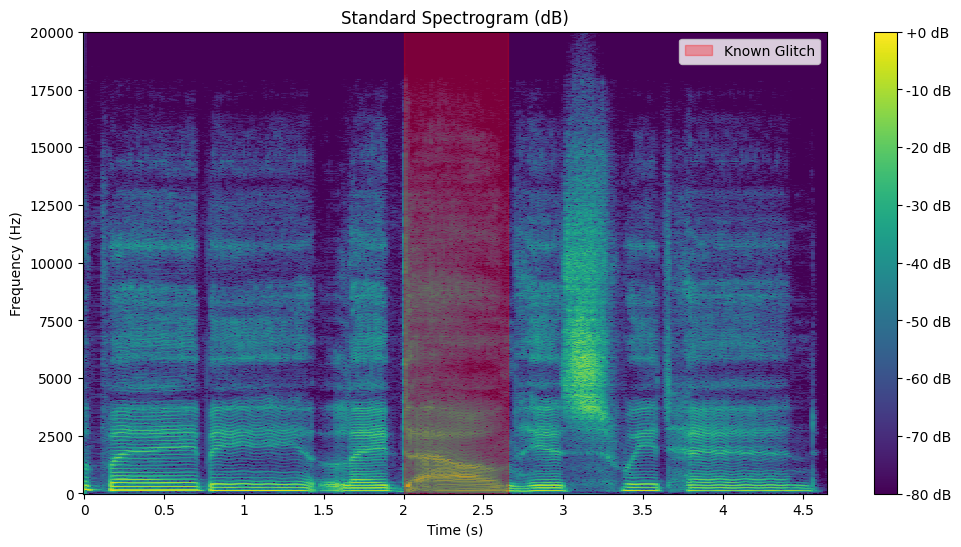

C:\Users\Mika\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


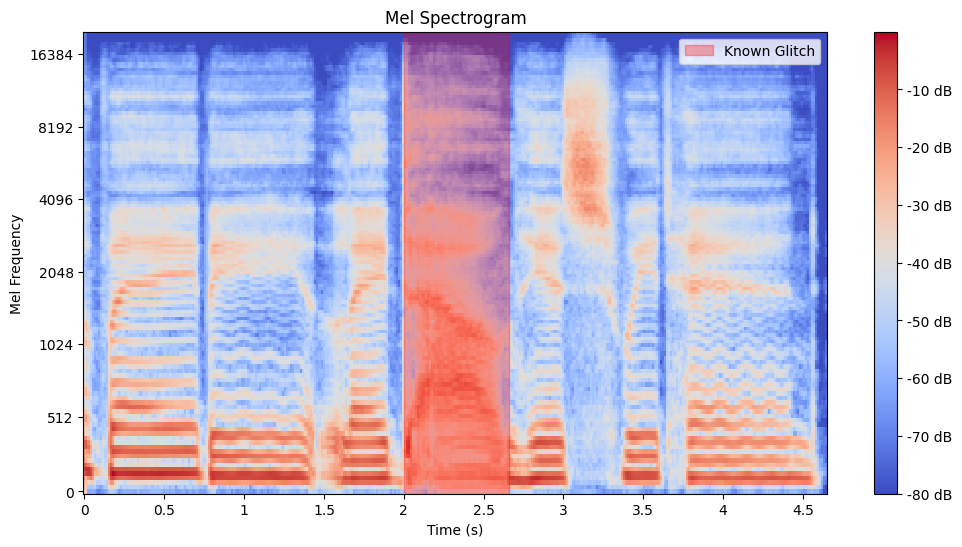

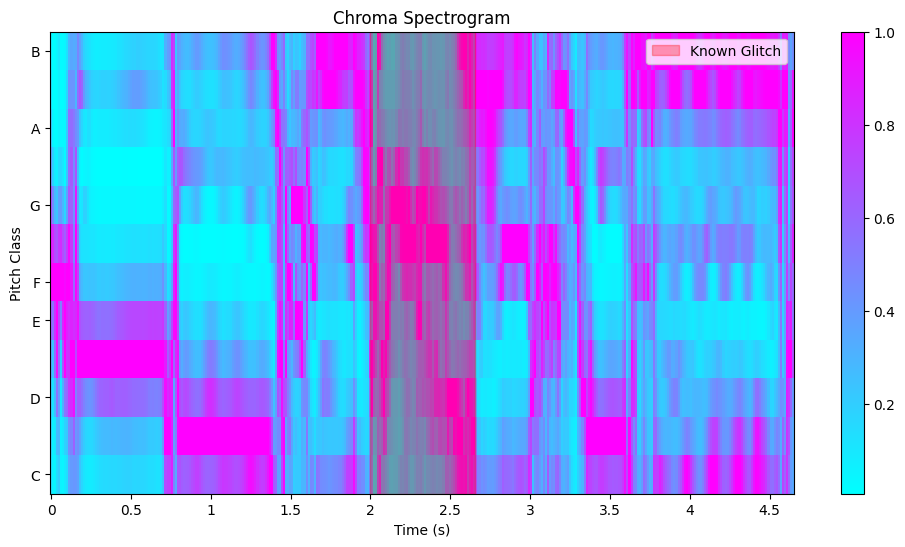

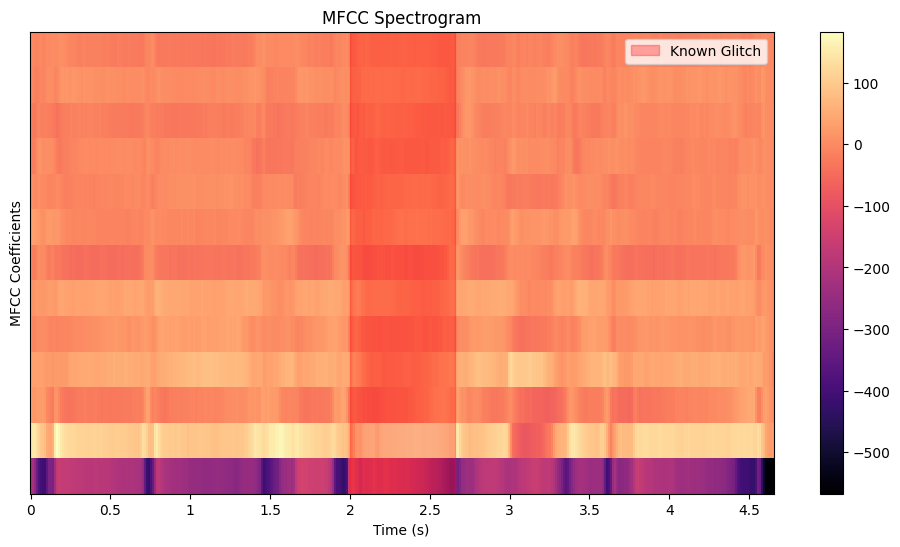

In [2]:
# Define a helper function to highlight the glitch
def highlight_glitch(ax, glitch_start, glitch_end, plot_start_time):
    """
    Highlights the glitch region on the given axis.
    
    Args:
        ax: The axis on which to highlight.
        glitch_start: The start time of the glitch (absolute).
        glitch_end: The end time of the glitch (absolute).
        plot_start_time: The start time of the plotted signal (absolute).
    """
    ax.axvspan(
        glitch_start - plot_start_time,  # Adjust to local plot time
        glitch_end - plot_start_time,    # Adjust to local plot time
        color='red', alpha=0.3, label='Known Glitch'
    )

# Plot 1: Standard Spectrogram
# The Standard Spectrogram represents the distribution of signal energy across time and frequency.
# It shows detailed frequency content, making it useful for analyzing harmonic structures and noise.
plt.figure(figsize=(12, 6))
S = librosa.stft(signal)  # Short-Time Fourier Transform
S_db = librosa.amplitude_to_db(abs(S), ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
highlight_glitch(plt.gca(), glitch_start_adjusted, glitch_end_adjusted, start_time)
plt.colorbar(format="%+2.0f dB")
plt.title('Standard Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

# Plot 2: Mel Spectrogram
# The Mel Spectrogram maps frequencies to the Mel scale, mimicking human auditory perception.
# It focuses on perceptually relevant frequency bands, making it ideal for speech and timbre analysis.
plt.figure(figsize=(12, 6))
S_mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
highlight_glitch(plt.gca(), glitch_start_adjusted, glitch_end_adjusted, start_time)
plt.colorbar(format="%+2.0f dB")
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.legend()
plt.show()

# Plot 3: Chroma Spectrogram
# The Chroma Spectrogram represents the energy distribution across the 12 pitch classes (chroma bins).
# It emphasizes harmonic content, making it useful for analyzing melodies and chords.
plt.figure(figsize=(12, 6))
S_chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
librosa.display.specshow(S_chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='cool')
highlight_glitch(plt.gca(), glitch_start_adjusted, glitch_end_adjusted, start_time)
plt.colorbar()
plt.title('Chroma Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.legend()
plt.show()

# Plot 4: MFCC Spectrogram
# The MFCC Spectrogram shows the Mel Frequency Cepstral Coefficients, which summarize spectral shape.
# MFCCs are widely used in speech and audio processing for characterizing the timbre of sounds.
plt.figure(figsize=(12, 6))
mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='magma')
highlight_glitch(plt.gca(), glitch_start_adjusted, glitch_end_adjusted, start_time)
plt.colorbar()
plt.title('MFCC Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.legend()
plt.show()


# 3. Feature Registration

In [3]:
import pandas as pd
import numpy as np
import librosa
from scipy.signal import butter, lfilter

# Global registry for feature extraction functions
FEATURE_REGISTRY = []

# Decorator to register feature functions
def register_feature(func):
    FEATURE_REGISTRY.append(func)
    return func

@register_feature
def glitch_frequency_concentration(signal, sr):
    """
    Calculates a feature based on energy concentration in specific frequency bands
    identified as characteristic of the glitch.
    Args:
        signal (np.ndarray): Audio signal.
        sr (int): Sampling rate.
    Returns:
        pd.DataFrame: Feature values across time.
    """
    # Short-Time Fourier Transform (STFT)
    S = np.abs(librosa.stft(signal, n_fft=2048, hop_length=512))**2
    freqs = np.linspace(0, sr / 2, S.shape[0])

    # Define frequency bands
    low_mid_band = (freqs >= 300) & (freqs <= 1000)
    high_band = (freqs > 3000)

    # Compute band energies
    low_mid_energy = np.sum(S[low_mid_band, :], axis=0)
    high_band_energy = np.sum(S[high_band, :], axis=0)
    total_energy = np.sum(S, axis=0)

    # Compute the concentration feature
    concentration = (low_mid_energy / (total_energy + 1e-6)) - (high_band_energy / (total_energy + 1e-6))

    # Create a time axis
    time = librosa.times_like(concentration, sr=sr, hop_length=512)

    # Normalize feature (optional)
    concentration = (concentration - np.min(concentration)) / (np.max(concentration) - np.min(concentration) + 1e-6)

    # Return as DataFrame
    return pd.DataFrame({"Time (s)": time, "Glitch Frequency Concentration": concentration})


@register_feature
def glitch_spectral_signature(signal, sr):
    """
    Custom feature to capture the spectral signature of the glitch.
    Combines spectral energy ratios and flatness to detect anomalies.
    """
    # Short-Time Fourier Transform (STFT)
    S = np.abs(librosa.stft(signal))
    freqs = np.linspace(0, sr / 2, S.shape[0])

    # Calculate frequency bands
    low_mid_band = (freqs >= 300) & (freqs <= 1000)
    high_band = (freqs > 1000)

    # Calculate energy in each band
    total_energy = np.sum(S**2, axis=0)
    low_mid_energy = np.sum(S[low_mid_band]**2, axis=0)
    high_band_energy = np.sum(S[high_band]**2, axis=0)

    # Compute energy ratios
    low_mid_ratio = low_mid_energy / (total_energy + 1e-6)
    high_band_ratio = high_band_energy / (total_energy + 1e-6)

    # Spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(S=S)

    # Combine features
    time = librosa.times_like(low_mid_ratio, sr=sr, hop_length=512)
    combined_feature = (
        low_mid_ratio - high_band_ratio
    ) * spectral_flatness.mean(axis=0)

    return pd.DataFrame({
        "Time (s)": time,
        "Glitch Spectral Signature": combined_feature
    })

@register_feature
def low_mid_band_energy(signal, sr, low_cutoff=300, high_cutoff=1000):
    """
    Calculates the energy in the 300 Hz to 1 kHz band to distinguish the glitch.
    """
    from scipy.signal import butter, lfilter

    nyquist = sr / 2
    b, a = butter(N=4, Wn=[low_cutoff / nyquist, high_cutoff / nyquist], btype="band")
    band_signal = lfilter(b, a, signal)
    energy = librosa.feature.rms(y=band_signal)
    time = librosa.times_like(energy[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Low-Mid Band Energy": energy[0]})

@register_feature
def glitch_band_energy(signal, sr, low_cutoff=3000, high_cutoff=7000):
    """
    Calculates the energy in the 3-7 kHz band to distinguish the glitch.
    """
    from scipy.signal import butter, lfilter

    nyquist = sr / 2
    b, a = butter(N=4, Wn=[low_cutoff / nyquist, high_cutoff / nyquist], btype="band")
    band_signal = lfilter(b, a, signal)
    energy = librosa.feature.rms(y=band_signal)
    time = librosa.times_like(energy[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Glitch Band Energy": energy[0]})

@register_feature
def glitch_zero_crossing_rate(signal, sr):
    """
    Calculates zero-crossing rate to identify high-frequency, noisy segments.
    """
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    time = librosa.times_like(zcr[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Zero Crossing Rate": zcr[0]})

@register_feature
def high_frequency_energy(signal, sr, cutoff=1000):
    """
    Extracts energy in the high-frequency range above the specified cutoff.
    """
    from scipy.signal import butter, lfilter

    nyquist = sr / 2
    b, a = butter(N=4, Wn=cutoff / nyquist, btype="high", analog=False)
    high_freq_signal = lfilter(b, a, signal)
    energy = librosa.feature.rms(y=high_freq_signal)
    time = librosa.times_like(energy[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "High-Frequency Energy": energy[0]})

@register_feature
def custom_glitch_feature(signal, sr):
    """
    Custom feature combining pitch instability, pitch confidence, and amplitude oscillations.
    """
    # Step 1: Extract pitch and confidence
    f0, _, voiced_prob = librosa.pyin(
        signal,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7'),
        sr=sr
    )
    time = librosa.times_like(f0, sr=sr)

    # Step 2: Calculate pitch instability (rate of change in pitch)
    pitch_delta = np.abs(np.diff(f0, prepend=f0[0]))  # Prepend to match length

    # Step 3: Extract high-frequency oscillations in amplitude (modulation energy)
    from scipy.signal import hilbert, butter, lfilter

    envelope = np.abs(hilbert(signal))  # Amplitude envelope
    nyquist = sr / 2
    b, a = butter(N=4, Wn=10 / nyquist, btype="high", analog=False)  # High-pass filter
    modulation = lfilter(b, a, envelope)
    modulation_energy = np.mean(modulation ** 2)

    # Step 4: Combine into a single feature
    # Normalize components for equal contribution
    pitch_instability_norm = pitch_delta / np.nanmax(pitch_delta) if np.nanmax(pitch_delta) > 0 else pitch_delta
    pitch_confidence_norm = 1 - voiced_prob  # Invert confidence (lower confidence = higher anomaly)
    modulation_energy_norm = modulation_energy / np.nanmax(modulation_energy) if np.nanmax(modulation_energy) > 0 else modulation_energy

    # Combine components
    glitch_feature = (
        pitch_instability_norm +
        pitch_confidence_norm +
        modulation_energy_norm
    )

    return pd.DataFrame({
        "Time (s)": time,
        "Custom Glitch Feature": glitch_feature
    })

@register_feature
def harmonic_to_noise_ratio(signal, sr):
    harmonic = librosa.effects.harmonic(signal)
    noise = signal - harmonic
    hnr = np.var(harmonic) / (np.var(noise) + 1e-6)  # Avoid division by zero
    time = np.linspace(0, len(signal) / sr, len(signal))
    return pd.DataFrame({"Time (s)": time, "Harmonic-to-Noise Ratio": hnr * np.ones_like(time)})

@register_feature
def modulation_rate(signal, sr):
    """
    Measures the rate of amplitude oscillations (modulation rate) in the signal.
    """
    from scipy.signal import hilbert, find_peaks

    envelope = np.abs(hilbert(signal))  # Amplitude envelope
    peaks, _ = find_peaks(envelope, distance=sr//50)  # Peaks in envelope (modulation rate ~50 Hz)
    time = np.linspace(0, len(signal) / sr, len(signal))
    modulation_rate = len(peaks) / (len(signal) / sr)  # Peaks per second

    return pd.DataFrame({"Time (s)": time, "Modulation Rate": modulation_rate * np.ones_like(time)})

@register_feature
def spectral_centroid_glitch(signal, sr):
    """
    Computes the spectral centroid, focusing on high-frequency activity during the glitch.
    """
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    time = librosa.times_like(centroid[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Spectral Centroid": centroid[0]})

@register_feature
def zero_crossing_rate_glitch(signal, sr):
    """
    Computes the zero-crossing rate to detect noisy behavior during the glitch.
    """
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    time = librosa.times_like(zcr[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Zero Crossing Rate": zcr[0]})

@register_feature
def pitch_f0(signal, sr):
    f0, _, _ = librosa.pyin(signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
    time = librosa.times_like(f0, sr=sr)
    return pd.DataFrame({"Time (s)": time, "Pitch (Hz)": f0})

@register_feature
def pitch_confidence(signal, sr):
    _, _, voiced_prob = librosa.pyin(signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
    time = librosa.times_like(voiced_prob, sr=sr)
    return pd.DataFrame({"Time (s)": time, "Pitch Confidence": voiced_prob})

@register_feature
def mfcc_dynamics(signal, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    time = librosa.times_like(mfcc[0], sr=sr)
    mfcc_variance = np.var(mfcc, axis=0)
    return pd.DataFrame({"Time (s)": time, "MFCC Variance": mfcc_variance})

@register_feature
def spectrogram_peak_energy(signal, sr, hop_length=512):
    S = np.abs(librosa.stft(signal, hop_length=hop_length))
    time = librosa.times_like(S[0], sr=sr, hop_length=hop_length)
    peak_energy = np.max(S, axis=0)
    return pd.DataFrame({"Time (s)": time, "Spectrogram Peak Energy": peak_energy})

@register_feature
def harmonic_to_noise_ratio(signal, sr):
    harmonic = librosa.effects.harmonic(signal)
    noise = signal - harmonic
    hnr = np.var(harmonic) / np.var(noise)
    time = np.linspace(0, len(signal) / sr, len(signal))
    return pd.DataFrame({"Time (s)": time, "Harmonic-to-Noise Ratio": hnr * np.ones_like(time)})

# High-Pass Energy
@register_feature
def high_pass_energy(signal, sr, cutoff=300):
    nyquist = sr / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(N=4, Wn=normal_cutoff, btype="high", analog=False)
    high_pass_signal = lfilter(b, a, signal)
    energy = librosa.feature.rms(y=high_pass_signal)
    time = librosa.times_like(energy[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "High-Pass Energy": energy[0]})

# Low-Frequency Energy
@register_feature
def low_pass_energy(signal, sr, cutoff=300):
    nyquist = sr / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(N=4, Wn=normal_cutoff, btype="low", analog=False)
    low_pass_signal = lfilter(b, a, signal)
    energy = librosa.feature.rms(y=low_pass_signal)
    time = librosa.times_like(energy[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Low-Frequency Energy": energy[0]})

# Spectral Flatness
@register_feature
def spectral_flatness(signal, sr):
    flatness = librosa.feature.spectral_flatness(y=signal)
    time = librosa.times_like(flatness[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Spectral Flatness": flatness[0]})

# Pitch (F0) and Confidence
@register_feature
def pitch_and_confidence(signal, sr):
    f0, voiced_flag, voiced_prob = librosa.pyin(signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
    time = librosa.times_like(f0, sr=sr)
    return pd.DataFrame({"Time (s)": time, "Pitch (Hz)": f0, "Pitch Confidence": voiced_prob})

# Spectral Flux
@register_feature
def spectral_flux(signal, sr):
    S = librosa.stft(signal)
    spectral_flux = np.mean(np.abs(np.diff(np.abs(S), axis=1)), axis=0)
    time = librosa.times_like(spectral_flux, sr=sr)
    return pd.DataFrame({"Time (s)": time, "Spectral Flux": spectral_flux})

@register_feature
def zero_crossing_rate(signal, sr):
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    time = librosa.times_like(zcr[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Zero Crossing Rate": zcr[0]})

@register_feature
def rms_energy(signal, sr):
    energy = librosa.feature.rms(y=signal)
    time = librosa.times_like(energy[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "RMS Energy": energy[0]})

@register_feature
def spectral_centroid(signal, sr):
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    time = librosa.times_like(centroid[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Spectral Centroid": centroid[0]})

@register_feature
def spectral_bandwidth(signal, sr):
    bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)
    time = librosa.times_like(bandwidth[0], sr=sr)
    return pd.DataFrame({"Time (s)": time, "Spectral Bandwidth": bandwidth[0]})


# 4. Feature Visualization

Extracting glitch_frequency_concentration...


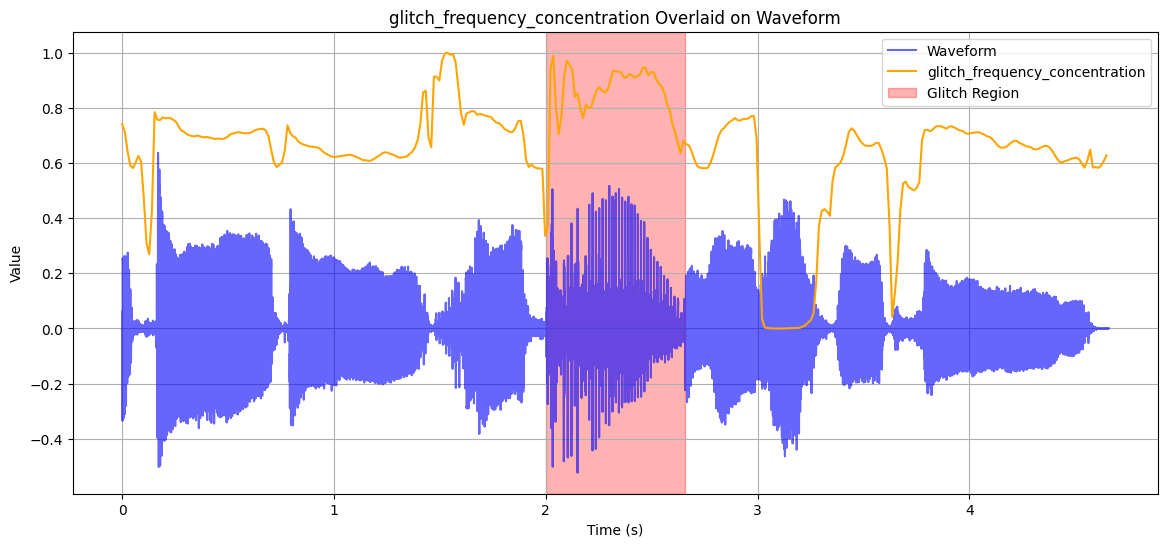

Extracting glitch_spectral_signature...


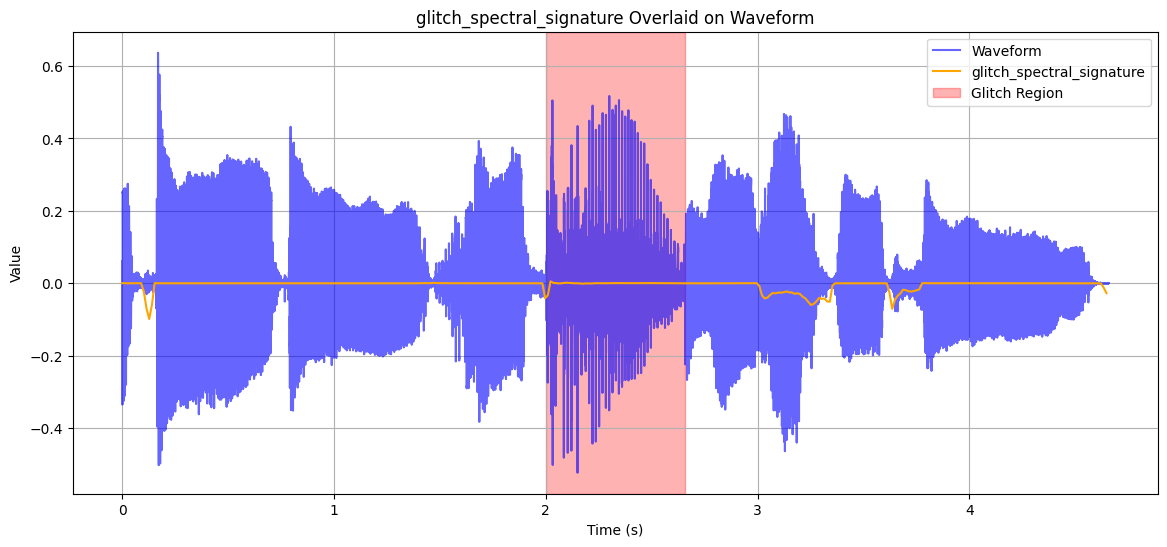

Extracting low_mid_band_energy...


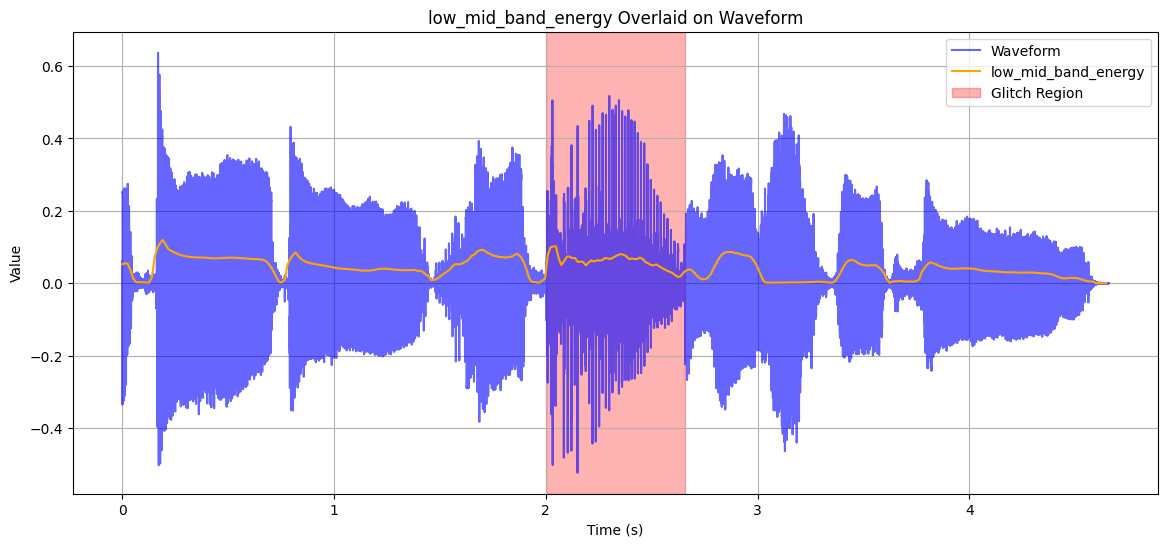

Extracting glitch_band_energy...


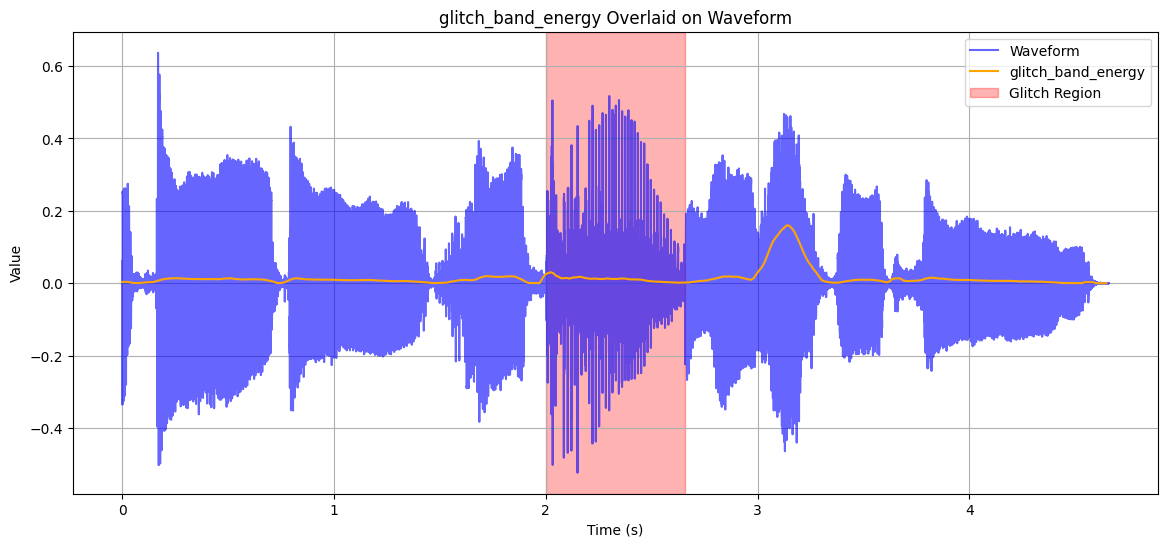

Extracting glitch_zero_crossing_rate...


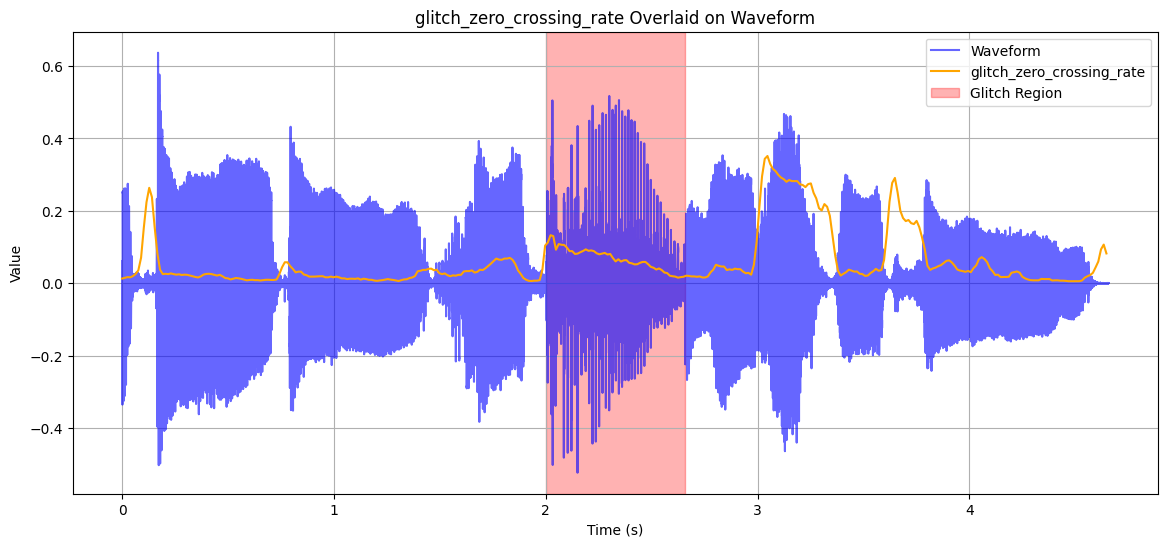

Extracting high_frequency_energy...


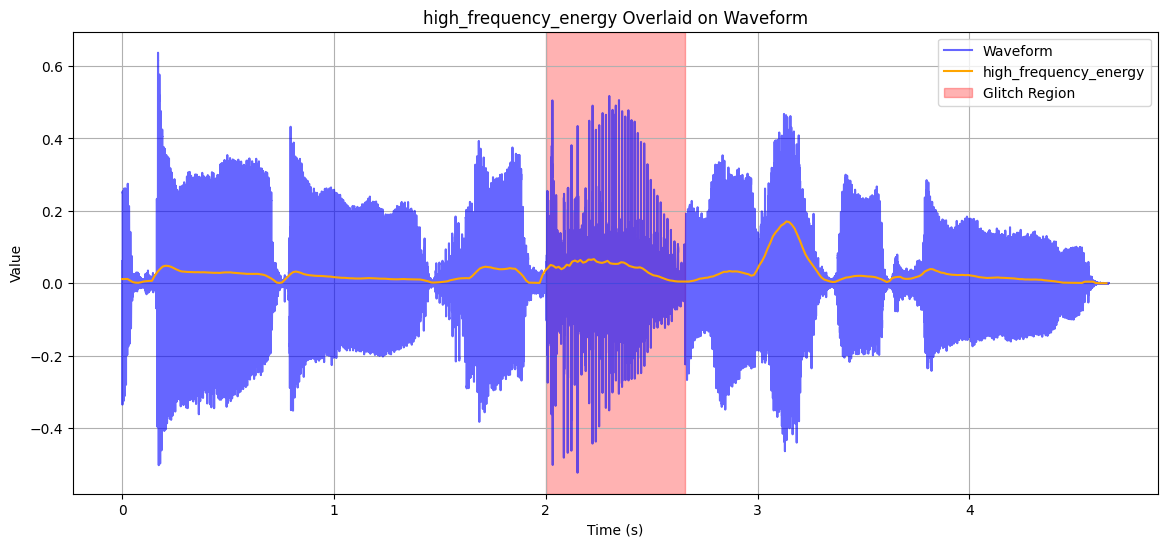

Extracting custom_glitch_feature...


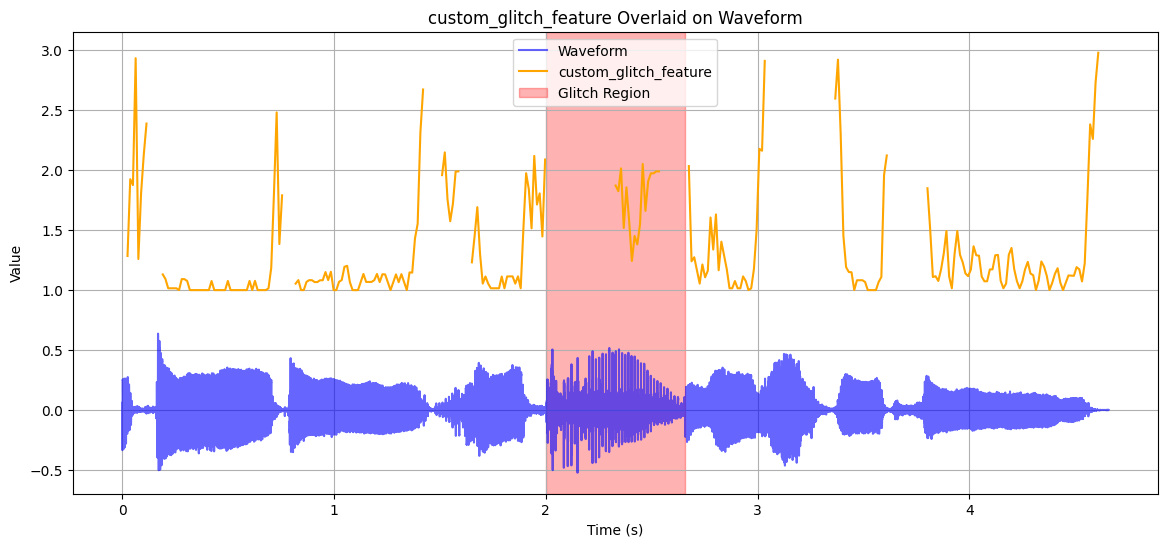

Extracting harmonic_to_noise_ratio...


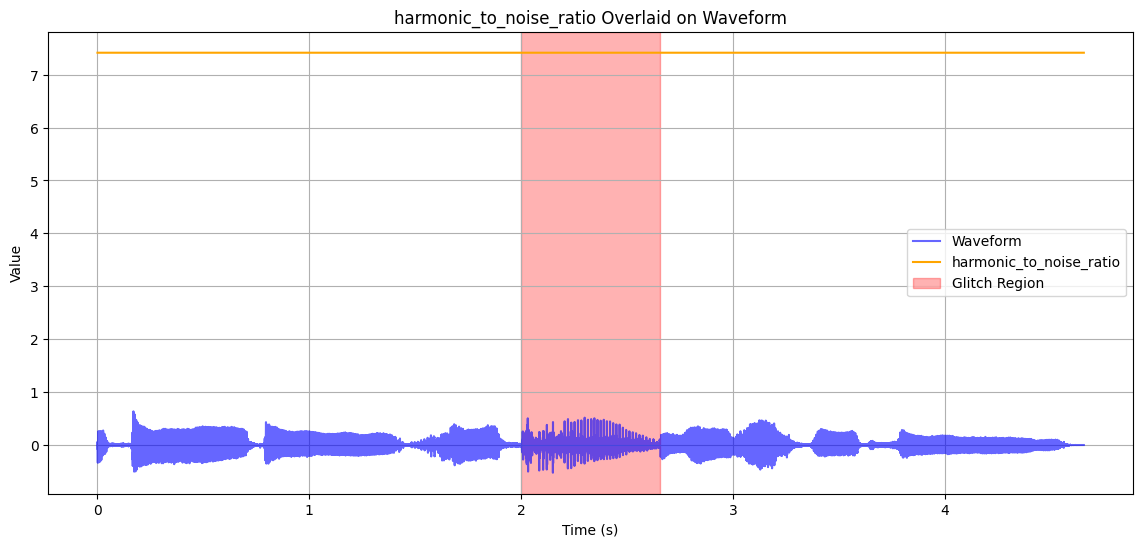

Extracting modulation_rate...


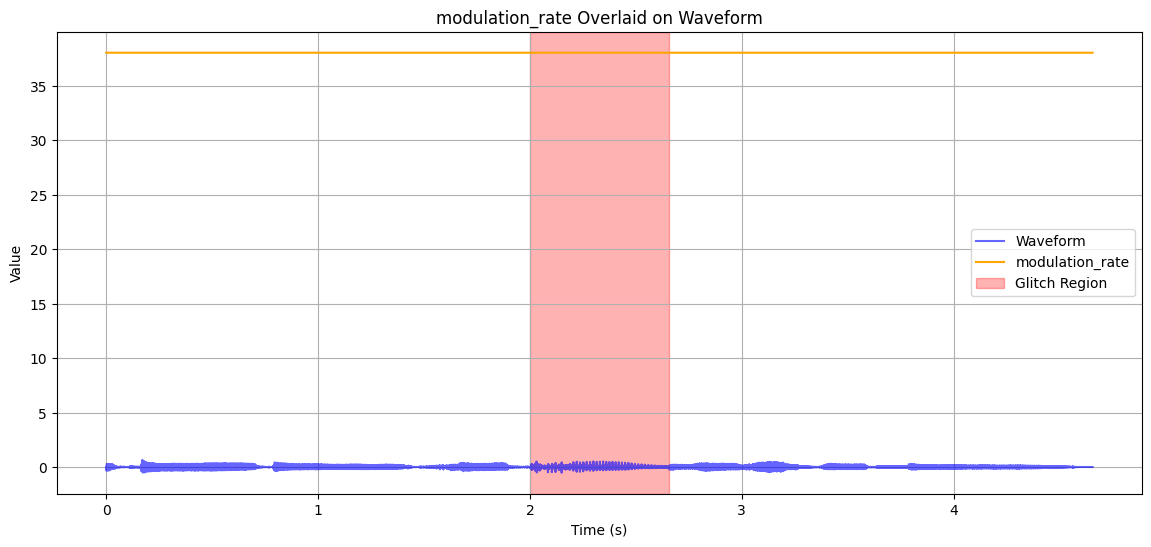

Extracting spectral_centroid_glitch...


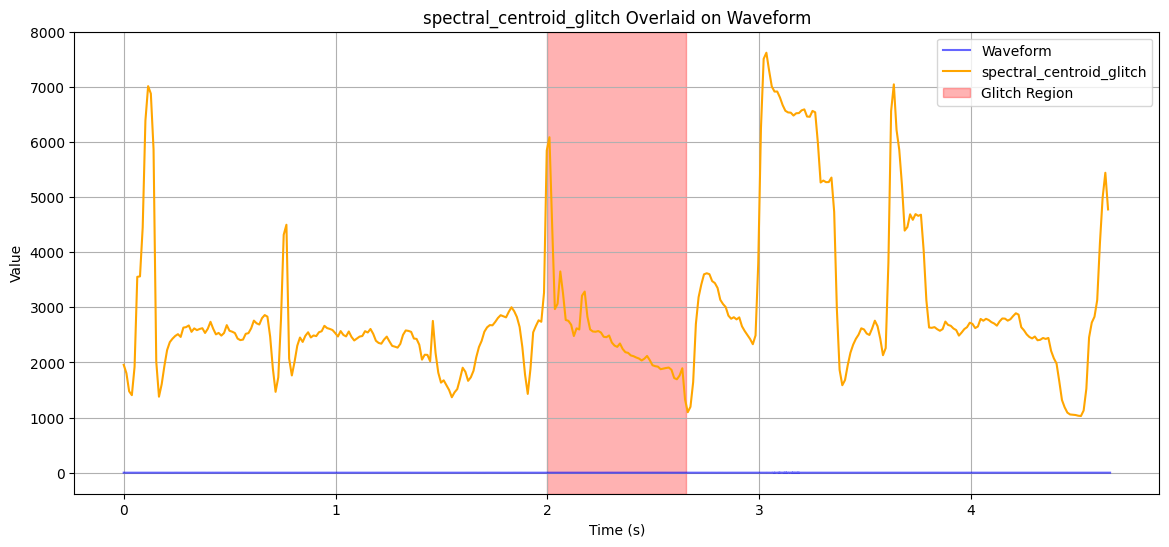

Extracting zero_crossing_rate_glitch...


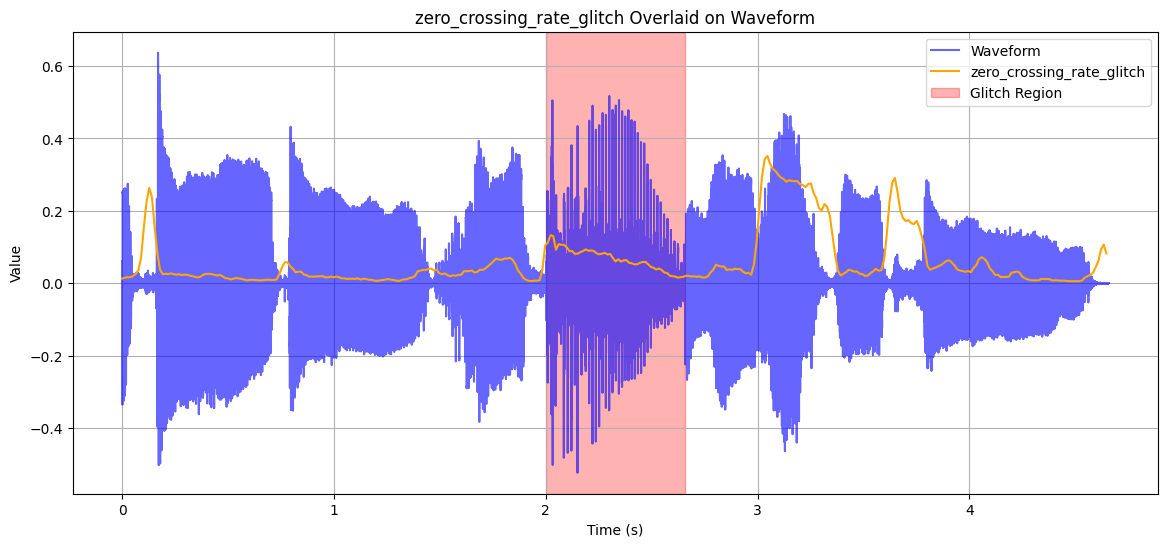

Extracting pitch_f0...


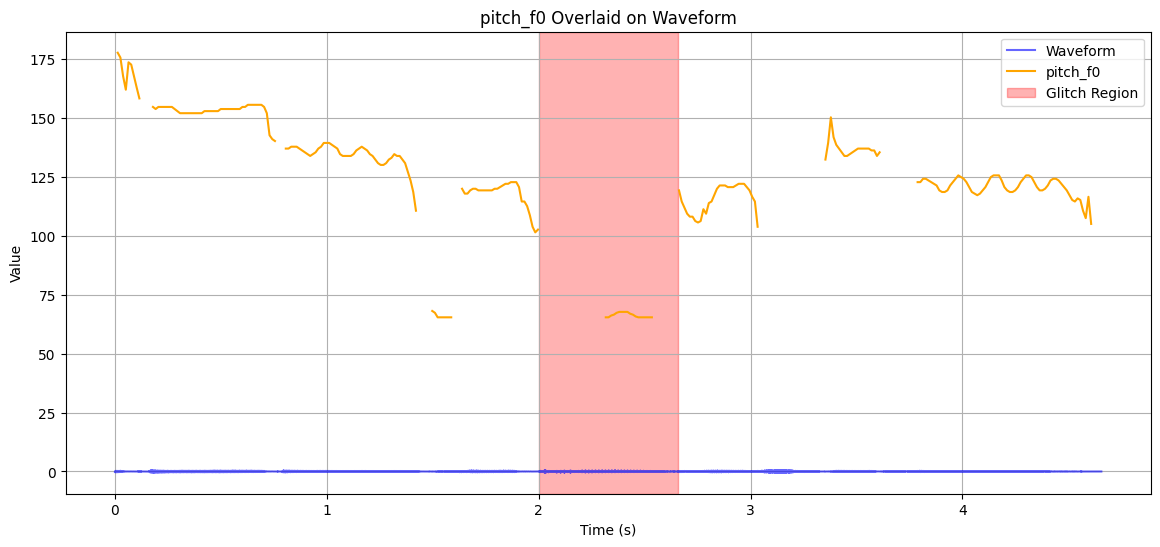

Extracting pitch_confidence...


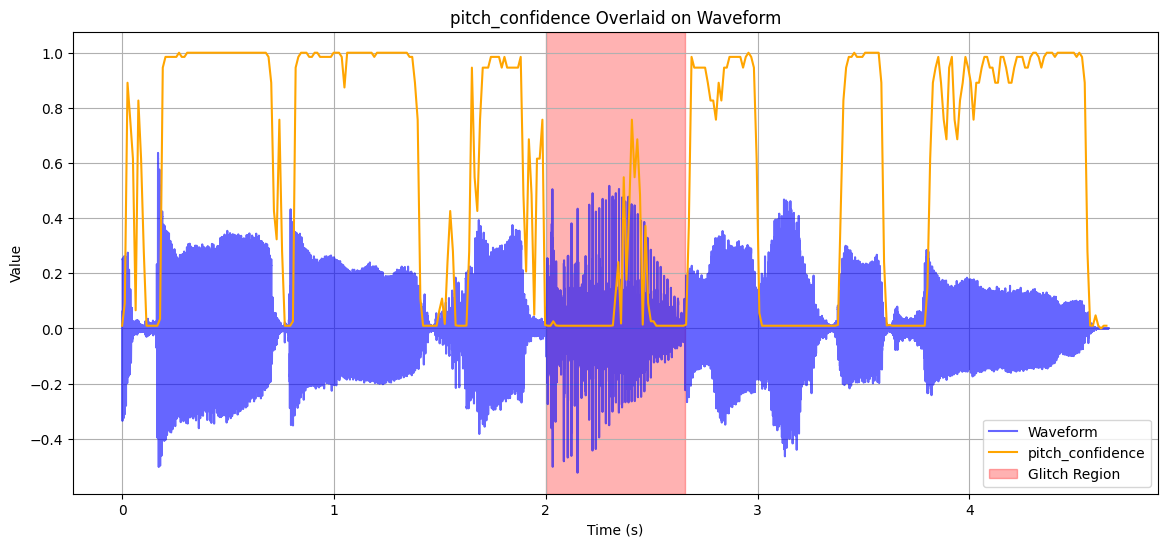

Extracting mfcc_dynamics...


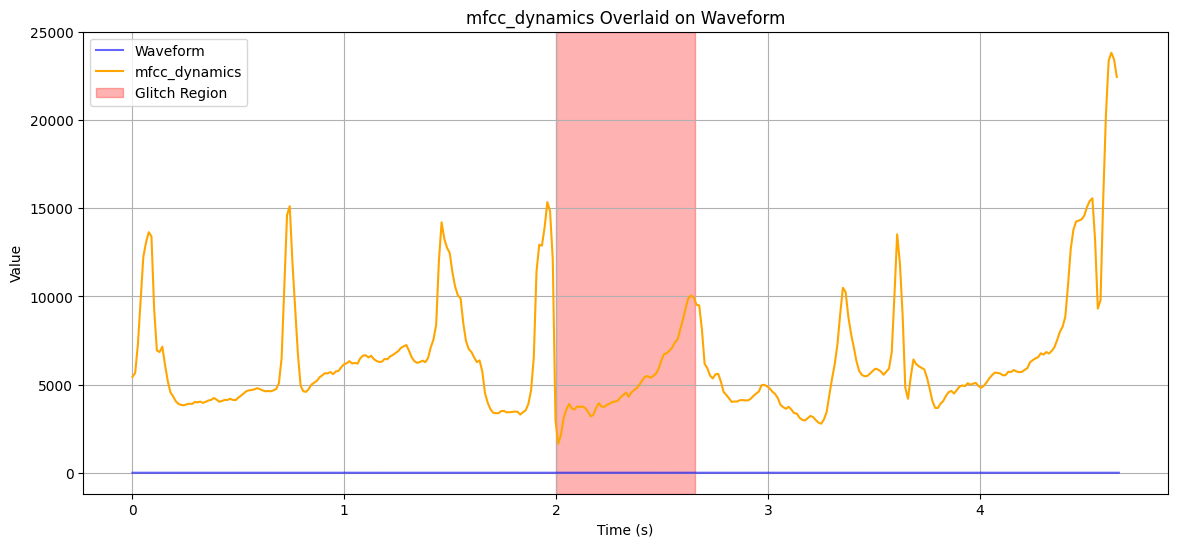

Extracting spectrogram_peak_energy...


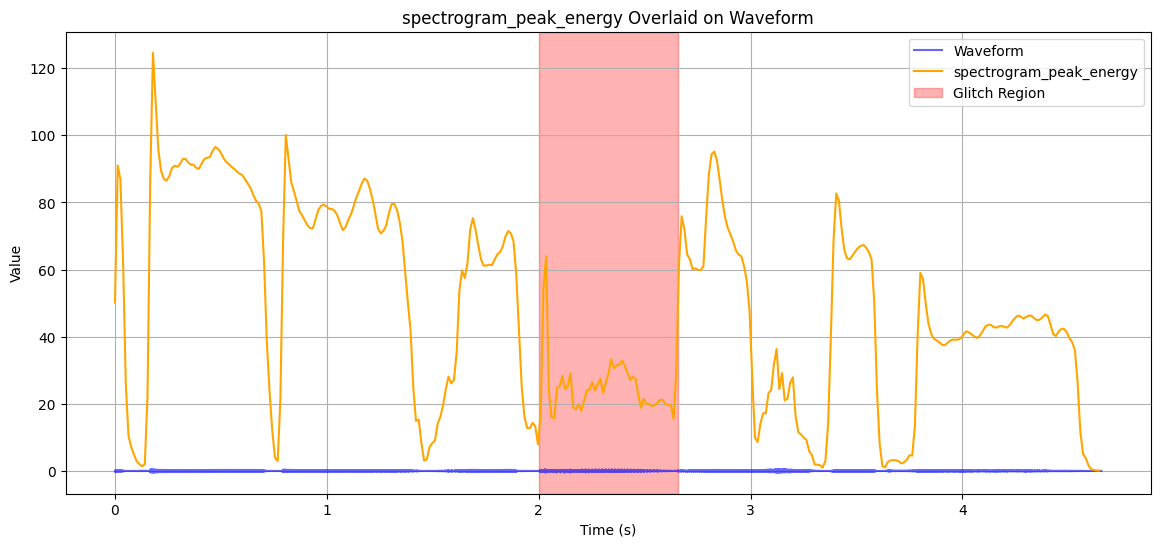

Extracting harmonic_to_noise_ratio...


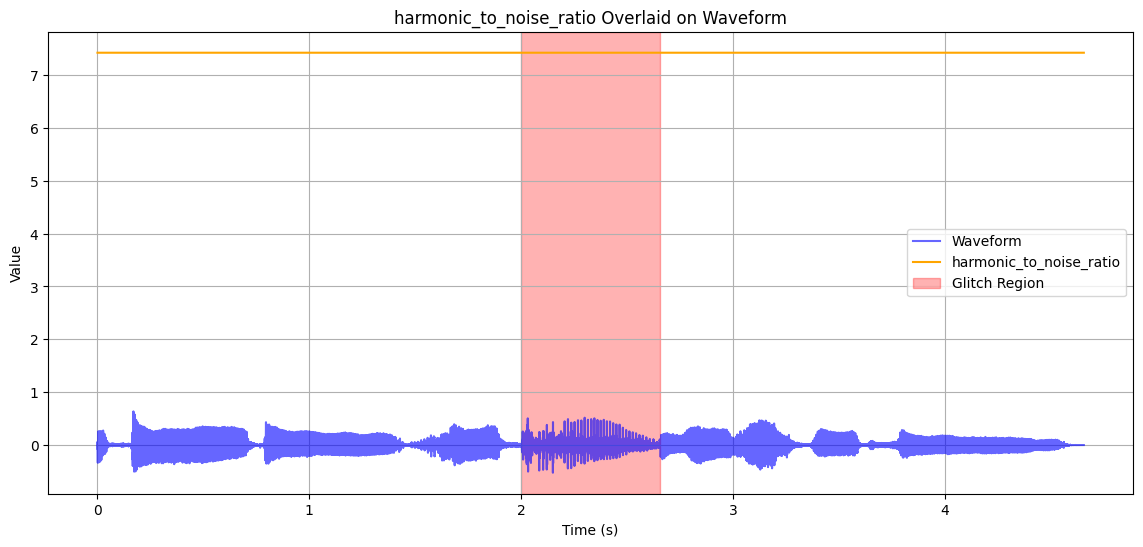

Extracting high_pass_energy...


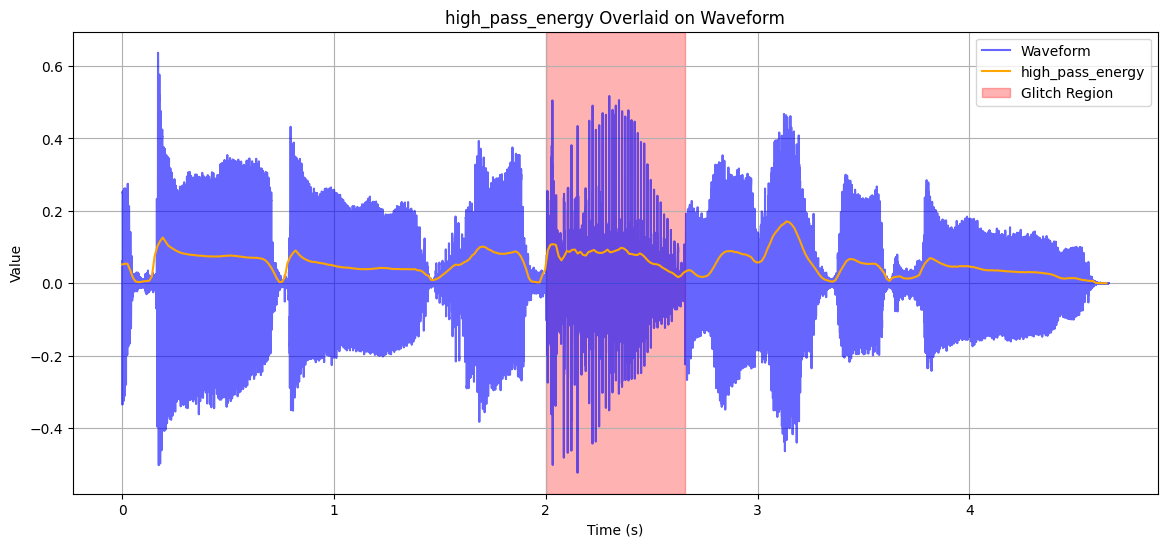

Extracting low_pass_energy...


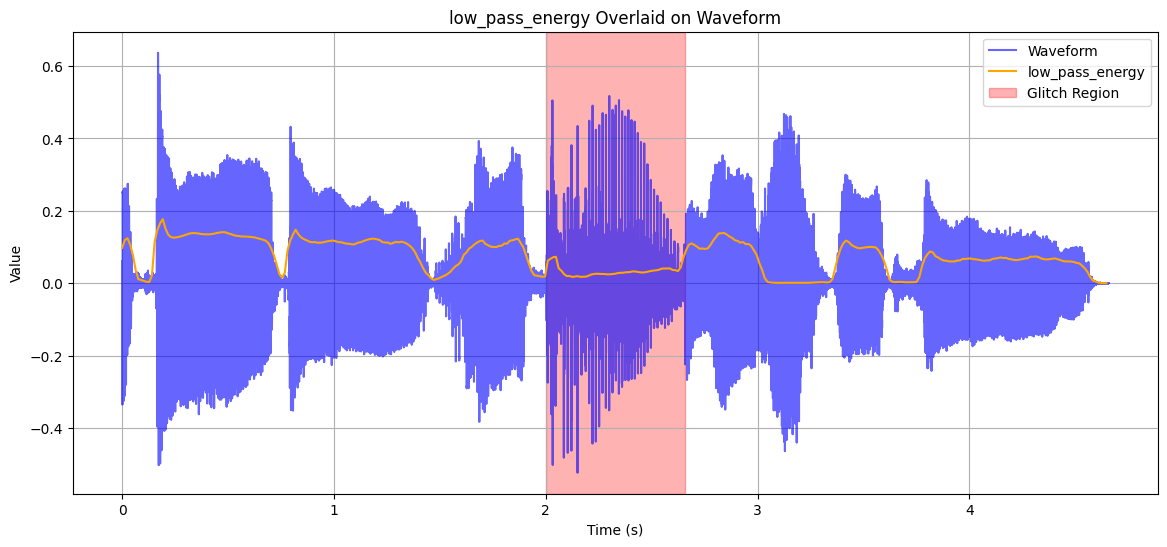

Extracting spectral_flatness...


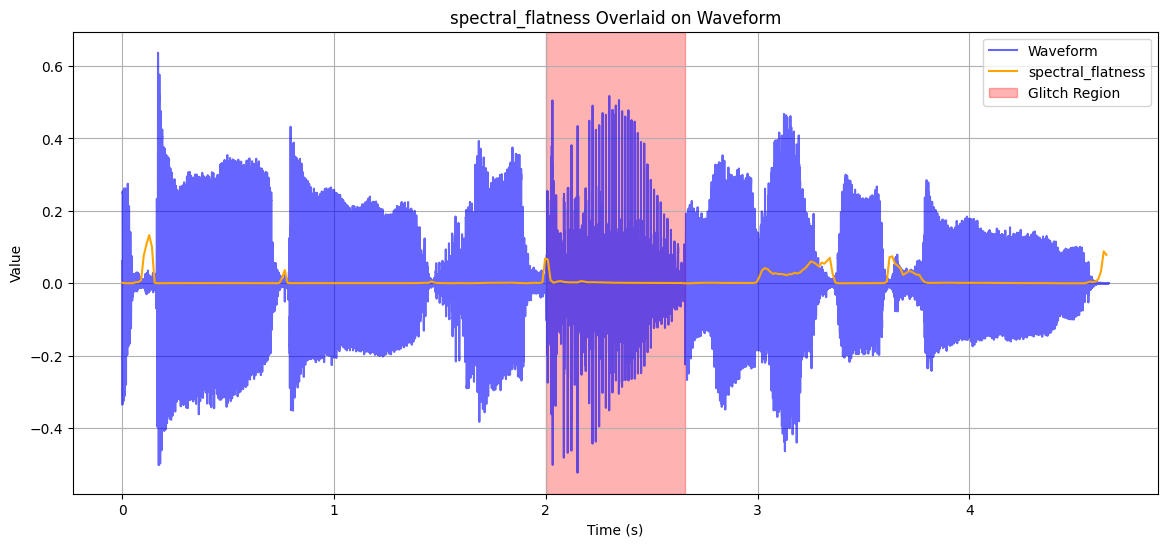

Extracting pitch_and_confidence...


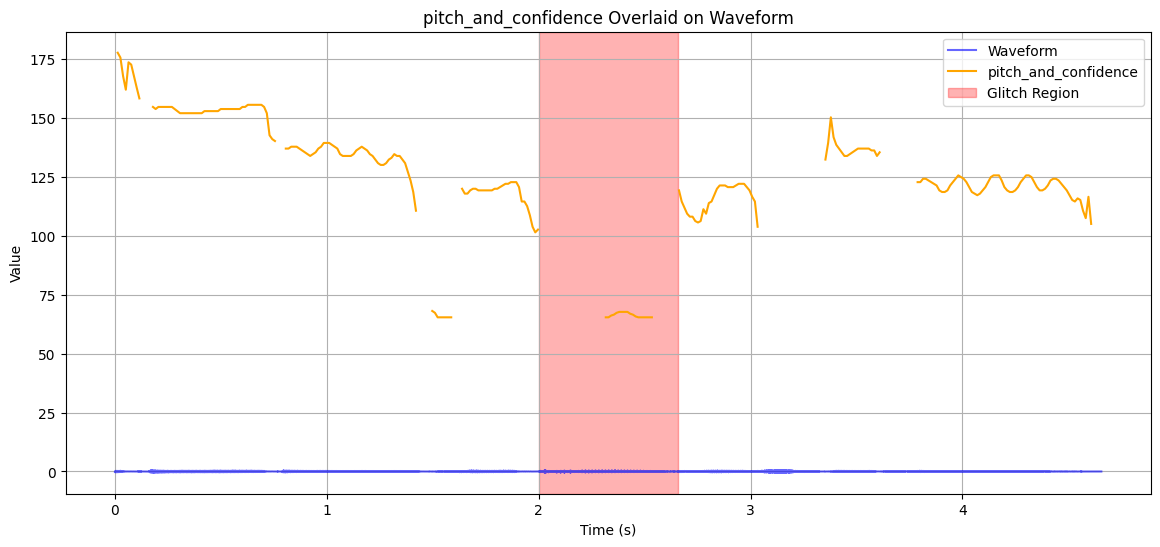

Extracting spectral_flux...


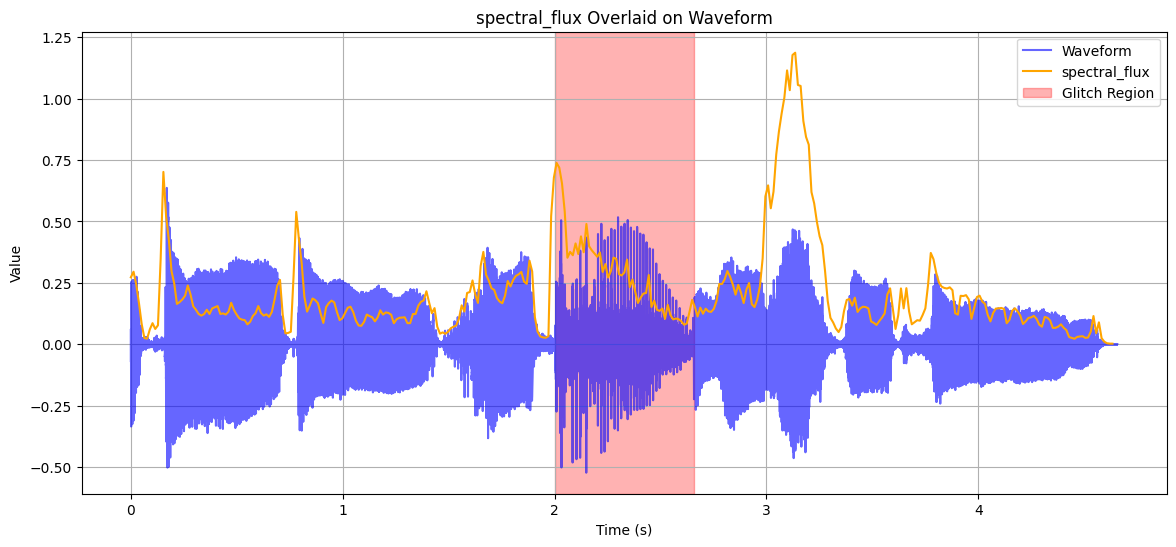

Extracting zero_crossing_rate...


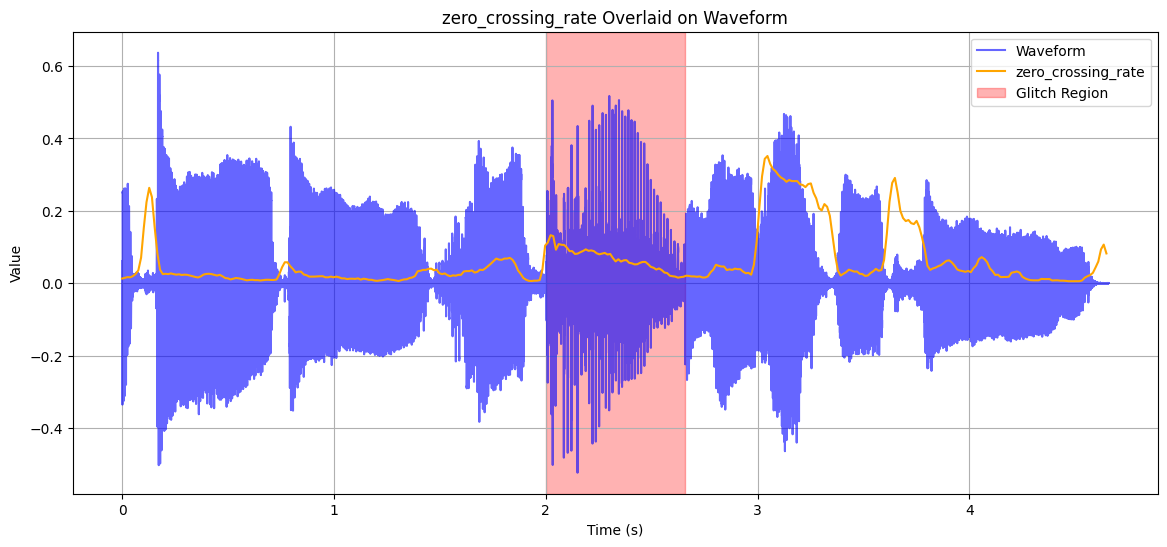

Extracting rms_energy...


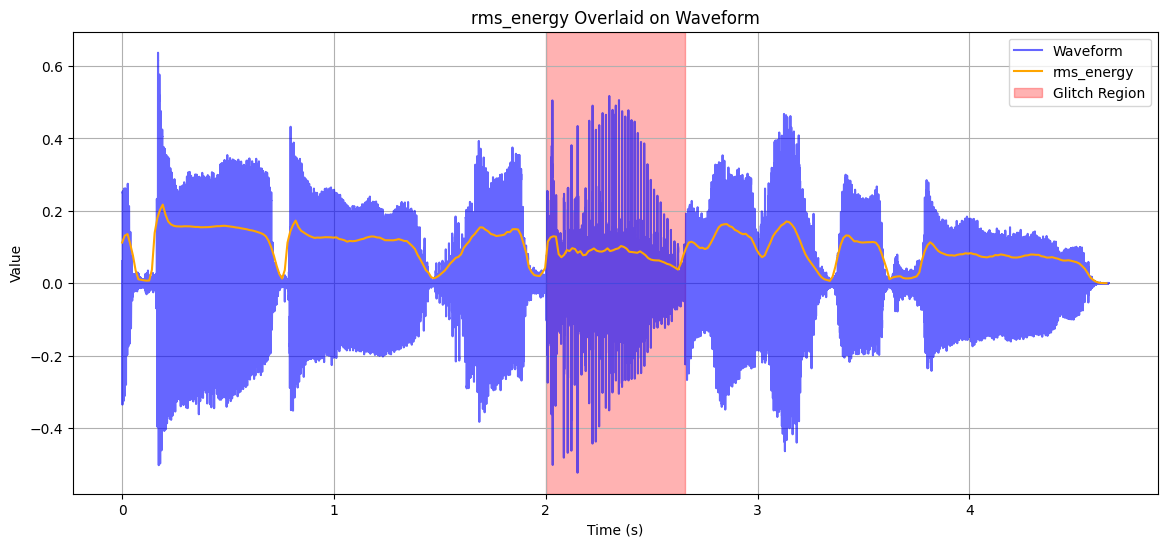

Extracting spectral_centroid...


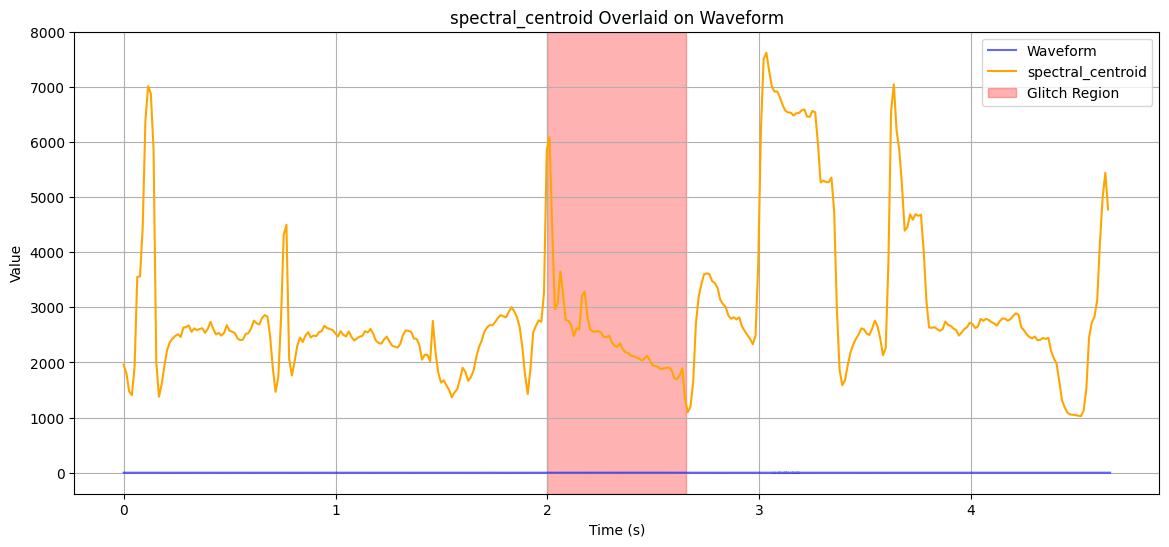

Extracting spectral_bandwidth...


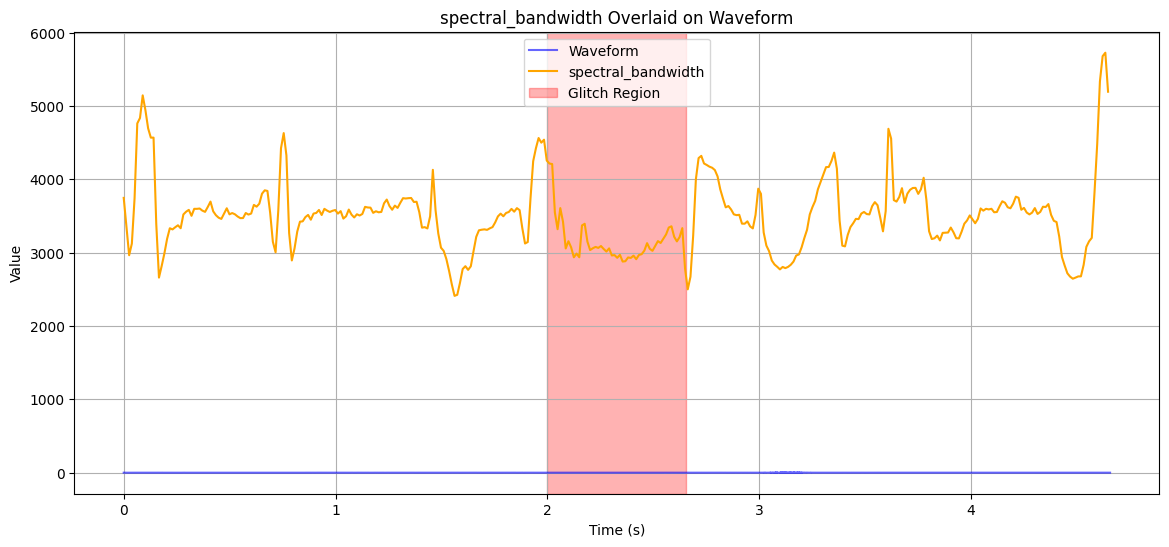

In [4]:
def visualize_feature_on_waveform(feature_name, feature_df, signal, sr, glitch_start, glitch_end):
    """
    Visualize a single feature overlaid on the waveform with the glitch region highlighted.
    Args:
        feature_name (str): Name of the feature.
        feature_df (pd.DataFrame): Feature data with "Time (s)" and feature values.
        signal (np.array): Truncated audio signal.
        sr (int): Sampling rate.
        glitch_start (float): Adjusted start time of the glitch.
        glitch_end (float): Adjusted end time of the glitch.
    """
    # Generate time axis for the truncated waveform
    time = np.linspace(0, len(signal) / sr, len(signal))

    # Create a new plot
    plt.figure(figsize=(14, 6))

    # Plot the waveform
    plt.plot(time, signal, color="blue", alpha=0.6, label="Waveform")

    # Overlay the feature
    plt.plot(
        feature_df["Time (s)"],
        feature_df.iloc[:, 1],
        color="orange",
        label=feature_name,
    )

    # Highlight the glitch region
    plt.axvspan(glitch_start, glitch_end, color="red", alpha=0.3, label="Glitch Region")

    # Add labels and legend
    plt.title(f"{feature_name} Overlaid on Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

# Compute and visualize features
features = {}
for feature_function in FEATURE_REGISTRY:
    feature_name = feature_function.__name__
    print(f"Extracting {feature_name}...")

    # Compute the feature
    feature_df = feature_function(signal, sr)
    features[feature_name] = feature_df

    # Visualize the feature immediately
    visualize_feature_on_waveform(feature_name, feature_df, signal, sr, glitch_start_adjusted, glitch_end_adjusted)
